# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [6]:
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    heading: float
    velocity: npt.NDArray[np.float64]


Observation: typing.TypeAlias = tuple[State, State]
Action: typing.TypeAlias = tuple[float, float]

In [ ]:
import metadrive
from metadrive import MetaDriveEnv
import gymnasium as gym
import typing

import torch
import torch.nn as nn
import torch.nn.functional as F

def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_metadrive_state(env: MetaDriveEnv) -> State:
    return State(heading=env.vehicle.heading_theta, velocity=env.vehicle.velocity[:2])

def next_state(env: MetaDriveEnv, s: State, a: Action) -> State:
    """
    runs the policy and returns the total reward
    """
    # reset
    env.reset()
    env.vehicle.set_position(env.vehicle.position, height=0.49)

    # allow car to settle
    for _ in range(5):
        env.step([0,0])

    # set the initial state
    env.vehicle.set_velocity(s.velocity)
    env.vehicle.set_heading_theta(s.heading)
    
    # run the simulator
    env.step(a)

    # get the new state
    s_prime = get_metadrive_state(env)

    # allow car to settle (if rendering)
    if env.config.use_render:
        for _ in range(10):
            env.step([0,0])

    return s_prime

def gen_scenario() -> tuple[State, Action]:
    """
    Generates a random scenario
    """
    # generate a random state
    velocity = np.random.multivariate_normal([0, 0], np.eye(2) * 10)
    heading = normalize_angle(np.arctan2(velocity[1], velocity[0]) + np.random.normal(0, 0.1))

    s = State(heading=heading, velocity=velocity)

    # generate a random action
    steer = np.random.uniform(-1, 1)
    throttle = np.random.uniform(-1, 1)
    a = (steer, throttle)

    return s, a

def state_batch_to_tensor(states: list[State], device: torch.device) -> torch.Tensor:
    """
    Reshape the state from State to a tensor of shape (batch_size, 3)
    """

    return torch.tensor(np.stack([
        [st.velocity[0], st.velocity[1], st.heading] for st in states
    ]), dtype=torch.float32, device=device)

def action_batch_to_tensor(actions: list[Action], device: torch.device) -> torch.Tensor:
    """
    Reshape the action from Action to a tensor of shape (batch_size, 2)
    """
    return torch.tensor(np.stack(actions), dtype=torch.float32, device=device)

def obs_batch_to_tensor(obs: list[Observation], device: torch.device) -> torch.Tensor:
    """
    Reshape the observation from tuple[State, State] to a tensor of shape (batch_size, 3, 2)
    """

    observations = []

    for st0, st1 in obs:
        observations.append(np.array([
            [st0.velocity[0], st1.velocity[0]], 
            [st0.velocity[1], st1.velocity[1]],
            [st0.heading, st1.heading]
        ]))

    return torch.tensor(np.stack(observations), dtype=torch.float32, device=device)

In [111]:
DATASET_SIZE = 100000

s0_dataset = []
a_dataset = []
s1_dataset = []
for _ in range(DATASET_SIZE):
    s0, a = gen_scenario()
    s1 = next_state(env, s0, a)
    s0_dataset.append(s0)
    a_dataset.append(a)
    s1_dataset.append(s1)

KeyboardInterrupt: 

In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create a model that attempts to predict the next state given the current state and the action: (throttle and steering)
# each state contains: velocity_x, velocity_y, and heading
class MetadriveModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3) + (batch_size, 2) = (batch_size, 5)
        # output shape: (batch_size, 3)
        self.fc1 = nn.Linear(4, 512) # Bx4 -> Bx512
        self.fc2 = nn.Linear(512, 512) # Bx512 -> Bx256
        self.fc3 = nn.Linear(512, 3) # Bx256 -> Bx3
    
    def forward(self, states: torch.Tensor, actions: torch.Tensor):
        # angle of the car's velocity vector
        phi = torch.atan2(states[:, 1], states[:, 0]) # B
    
        # magnitude of the car's velocity vector
        mag = torch.sqrt(states[:, 0]**2 + states[:, 1]**2) # B

        # heading error
        heading_diff = torch.remainder(states[:, 2] - phi, torch.pi*2) - torch.pi # B

        x = torch.cat([mag.unsqueeze(1), heading_diff.unsqueeze(1), actions], dim=1) # Bx1 + Bx1 + Bx2 -> Bx4
        x = F.relu(self.fc1(x)) # Bx4 -> Bx512
        x = F.relu(self.fc2(x)) # Bx512 -> Bx512
        x = F.relu(self.fc3(x)) # Bx512 -> Bx3
    
    
        # compute the rotation matrix that rotates into the world frame from the car's frame
        s = torch.sin(-phi)
        c = torch.cos(-phi)
        rot = torch.stack([
                torch.stack([c, -s]),
                torch.stack([s, c])
        ]).permute(2, 0, 1)
        
        # rotate the velocity vector into the world frame
        out_vel = torch.bmm(rot, x[:, :2].unsqueeze(2)).squeeze(2) # Bx2 -> Bx2

        out_heading = torch.remainder(x[:, 2] + phi, torch.pi*2) - torch.pi # B

        x = torch.cat([out_vel, out_heading.unsqueeze(1)], dim=1) # Bx2 + Bx1 -> Bx3 
        return x

def train_metadrive_model_step(
    mm: MetadriveModel,
    mm_optimizer: torch.optim.Optimizer,
    s0_batch: list[State],
    a_batch: list[Action],
    s1_batch: list[State],
) -> float: 
    device = deviceof(mm)

    s0_tensor = state_batch_to_tensor(s0_batch, device) 
    a_tensor = action_batch_to_tensor(a_batch, device)
    s1_tensor = state_batch_to_tensor(s1_batch, device)

    mm_optimizer.zero_grad()
    s1_pred_tensor = mm(s0_tensor, a_tensor)
    loss = F.mse_loss(s1_pred_tensor, s1_tensor)
    loss.backward()
    mm_optimizer.step()
    return float(loss.item())



In [9]:

def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(s_pred.velocity - s_true.velocity) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)

In [126]:

def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mm = MetadriveModel().to(device)

mm_optimizer = torch.optim.Adam(mm.parameters())

mm_step = 0
mm_losses = []

In [16]:
# disable logging from metadrive
import logging
import inspect
import metadrive.envs.base_env
logging.getLogger(inspect.getfile(metadrive.envs.base_env)).setLevel(logging.WARNING)

In [19]:
from metadrive import MetaDriveEnv

env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})

In [128]:
set_lr(mm_optimizer, 1e-4)
METADRIVE_MODEL_TRAIN_EPOCHS = 300
METADRIVE_MODEL_TRAIN_BATCH_SIZE = 256

while mm_step < METADRIVE_MODEL_TRAIN_EPOCHS:
    # s0_batch = []
    # a_batch = []
    # s1_batch = []
    # for _ in range(METADRIVE_MODEL_TRAIN_BATCH_SIZE):
    #     s0, a = gen_scenario()
    #     s1 = next_state(env, s0, a)
    #     s0_batch.append(s0)
    #     a_batch.append(a)
    #     s1_batch.append(s1)
    
    loss = train_metadrive_model_step(mm, mm_optimizer, s0_batch, a_batch, s1_batch)
    mm_losses.append(loss)
    mm_step += 1
    print(f"Step: {mm_step}, Loss: {loss:.3f}")

Step: 1, Loss: 8.002


Step: 2, Loss: 7.989
Step: 3, Loss: 7.987
Step: 4, Loss: 7.987
Step: 5, Loss: 7.986
Step: 6, Loss: 7.985
Step: 7, Loss: 7.984
Step: 8, Loss: 7.982
Step: 9, Loss: 7.981
Step: 10, Loss: 7.981
Step: 11, Loss: 7.980
Step: 12, Loss: 7.979
Step: 13, Loss: 7.977
Step: 14, Loss: 7.975
Step: 15, Loss: 7.973
Step: 16, Loss: 7.971
Step: 17, Loss: 7.970
Step: 18, Loss: 7.968
Step: 19, Loss: 7.967
Step: 20, Loss: 7.965
Step: 21, Loss: 7.961
Step: 22, Loss: 7.957
Step: 23, Loss: 7.955
Step: 24, Loss: 7.953
Step: 25, Loss: 7.951
Step: 26, Loss: 7.950
Step: 27, Loss: 7.949
Step: 28, Loss: 7.948
Step: 29, Loss: 7.946
Step: 30, Loss: 7.944
Step: 31, Loss: 7.942
Step: 32, Loss: 7.939
Step: 33, Loss: 7.938
Step: 34, Loss: 7.935
Step: 35, Loss: 7.935
Step: 36, Loss: 7.933
Step: 37, Loss: 7.932
Step: 38, Loss: 7.928
Step: 39, Loss: 7.927
Step: 40, Loss: 7.926
Step: 41, Loss: 7.925
Step: 42, Loss: 7.924
Step: 43, Loss: 7.923
Step: 44, Loss: 7.920
Step: 45, Loss: 7.918
Step: 46, Loss: 7.917
Step: 47, Loss: 7

In [122]:
s0_batch = s0_dataset
s1_batch = s1_dataset
a_batch = a_dataset

In [130]:
s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

In [131]:
s1_pred_tensor = mm(s0_tensor, a_tensor)

In [135]:
(s1_pred_tensor - s1_tensor)[:10]

tensor([[ 1.1667,  2.9695,  4.4899],
        [ 0.5519,  0.7008,  3.3958],
        [ 0.6296,  1.6970,  4.3906],
        [-0.9227, -1.3832, -3.0812],
        [ 3.6676,  5.0070,  3.2436],
        [-1.3597, -2.1210, -2.7319],
        [-5.0851,  2.1018,  3.1071],
        [-3.5377, -3.4137, -3.2566],
        [-0.9282, -0.7642, -3.1225],
        [-0.4535,  4.1280,  3.2502]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [133]:
(s1_pred_tensor - s0_tensor)

tensor([[ 0.9207,  3.1731,  4.4802],
        [ 1.2752,  1.6150,  3.3951],
        [ 1.3945,  2.1944,  4.3932],
        ...,
        [ 1.2769,  3.0160, -0.5113],
        [-3.5067, -3.7657, -2.9884],
        [ 1.3834,  3.4239,  3.5927]], device='cuda:0', grad_fn=<SubBackward0>)

In [137]:
s1_pred_tensor[:20]

tensor([[ 0.0000,  0.0000,  2.7420],
        [ 0.0000,  0.0000,  1.2008],
        [ 0.0000,  0.0000,  2.3655],
        [ 0.0000,  0.0000, -1.9847],
        [ 0.0000,  0.0000,  0.9817],
        [ 0.0000,  0.0000, -1.8402],
        [ 0.0000,  0.0000,  2.6574],
        [ 0.0000,  0.0000, -2.3281],
        [ 0.0000,  0.0000, -2.2658],
        [ 0.0000,  0.0000,  1.6190],
        [ 0.0000,  0.0000, -2.2673],
        [ 0.0000,  0.0000,  0.8900],
        [ 0.0000,  0.0000,  0.5883],
        [ 0.0000,  0.0000, -1.6388],
        [ 0.0000,  0.0000,  1.1275],
        [ 0.0000,  0.0000,  2.7509],
        [ 0.0000,  0.0000, -1.0631],
        [ 0.0000,  0.0000,  1.8921],
        [ 0.0000,  0.0000,  0.3799],
        [ 0.0000,  0.0000, -0.8267]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
env.close()

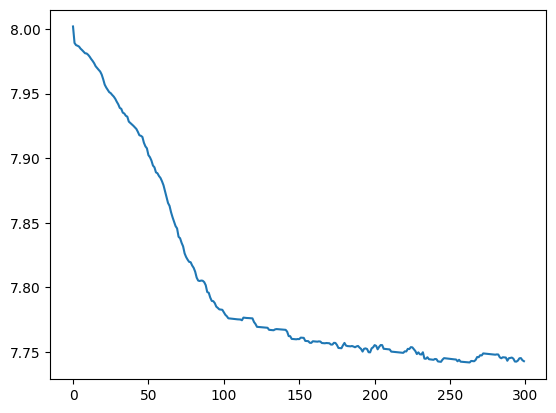

In [129]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(list(range(len(mm_losses))), mm_losses, label='MM')
plt.show()

Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [53]:
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(3, 512, 2) # Bx3x2 -> Bx512x1
        self.fc1 = nn.Linear(512, 256) # Bx512 -> Bx256
        self.fc2 = nn.Linear(256, 256) # Bx256 -> Bx256
        self.fc3 = nn.Linear(256, 2) # Bx256 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx3x2 -> Bx512x1
        x = torch.flatten(x, 1) # Bx512x1 -> Bx512
        x = F.relu(self.fc1(x)) # Bx512 -> Bx256
        x = F.relu(self.fc2(x)) # Bx256 -> Bx256
        x = self.fc3(x) # Bx256 -> Bx2
        return x

def train_idm_step(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_batch: list[Observation],
) -> float:
    device = deviceof(mm)

    assert deviceof(idm) == device

    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_batch = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_batch = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_batch, pred_action)

    loss = F.mse_loss(pred_s1, s1_batch)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [54]:
from protos import scenario_pb2
from tensorflow.data import TFRecordDataset
import tqdm
import os

def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return [f for f in files if os.path.isfile(f)]


files = getFiles('~/data/waymo/')

def parse_scenario(scenario: scenario_pb2.Scenario) -> list[State]:
    states = []
    for s in scenario.tracks[scenario.sdc_track_index].states:
        if s.valid:
            states.append(State(s.heading, np.array([s.velocity_x, s.velocity_y], dtype=np.float32)))
    return states


h: list[list[State]] = []

for file_path in tqdm.tqdm(files):
    for data in TFRecordDataset(file_path, compression_type="").as_numpy_iterator():
        scenario = scenario_pb2.Scenario()
        scenario.ParseFromString(data)
        h.append(parse_scenario(scenario))


2023-08-10 19:36:32.198575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 19:36:33.251851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  0%|          | 0/100 [00:00<?, ?it/s]2023-08-10 19:36:34.065985: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-10 19:36:34.085071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at l

KeyboardInterrupt: 

In [55]:
dataset: list[Observation] = []
for states in h:
    for i in range(len(states)-1):
        dataset.append((states[i], states[i+1]))

In [56]:
import random
random.shuffle(dataset)

In [57]:
idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.Adam(idm.parameters())

idm_step = 0
idm_losses = []

In [ ]:
set_lr(idm_optimizer, 1e-4)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 1000
INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE = 128

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    idm_step += 1
    idm_batch = idm_train_ds.sample(INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE)
    idm_loss = idm_train_step(idm_batch)
    if idm_step % 50 == 0:
        print(f"IDM Step {idm_step}: {idm_loss:.4f}")